## Installations

## Imports

In [ ]:
import pandas as pd
from tqdm import tqdm
import time
import os
import os
import re
from collections import Counter
import pickle
import lichess.api
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import TimeSeriesKMeans
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from tslearn.clustering import TimeSeriesKMeans, KShape, KernelKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as dist
from warnings import filterwarnings
from random import sample
from datetime import datetime, timezone
import os
import pandas as pd
from sklearn.metrics import classification_report
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

try:
  from tslearn.clustering import TimeSeriesKMeans
  from tslearn.clustering import silhouette_score
except:
  import sys
  !{sys.executable} -m pip install tslearn
  from tslearn.clustering import TimeSeriesKMeans
  from tslearn.clustering import silhouette_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
from sklearn import metrics
from dotenv import find_dotenv, load_dotenv

# Avoid showing warnings to keep the notebook outputs clean.
filterwarnings("ignore")

/home/ariel/anaconda3/envs/ml/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [ ]:
load_dotenv(find_dotenv())

PROJECT_PATH=os.getenv('PROJECT_PATH')
MAX_T=int(os.getenv('MAX_T'))
RISING_LABEL=1

In [ ]:
def read_file(file):
    df=pd.read_csv(file)

    return df


def get_all_players(df):
    all_whites=list(set(sorted(df["White"])))
    all_whites=sorted(all_whites)
    all_black=list(set(sorted(df["Black"])))
    all_black=sorted(all_black)
    all_players=list(set(all_whites+all_black))
    return all_players
def get_events_for_player(df,player):
    return Counter(list(df[(df["White"]==player)|(df["Black"]==player)]["Event"]))
def get_games_for_player(df,player):
    return df[(df["White"]==player)|(df["Black"]==player)]

def get_years_for_player(df,player):
    return dict(Counter(list(df[(df["White"]==player)|(df["Black"]==player)]["Year"])))
def get_years_for_player_game(df,player,game):
    return dict(Counter(list(df[((df["White"]==player)|(df["Black"]==player))&(df["Event"]==game)]["Year"])))
def get_players(df):
    w=list(df["White"])
    b=list(df["Black"])
    all=list(set((w+b)))
    return all

def get_games_for_player(df,player):
    player_black_df=df[df["Black"]==player]
    player_black_df=player_black_df[["UTCDate","BlackElo","UTCTime"]]
    player_black_df.rename(columns={'BlackElo':'Elo'},inplace=True)

    player_white_df=df[df["White"]==player]
    player_white_df=player_white_df[["UTCDate","WhiteElo","UTCTime"]]
    player_white_df.rename(columns={'WhiteElo':'Elo'},inplace=True)

    return pd.concat([player_black_df,player_white_df]).sort_values(by='UTCDate')


def date_to_num(date_str):
    # Parse the date string to datetime object
    date_obj = datetime.strptime(date_str, "%Y.%m.%d %H:%M:%S")

    # Convert the datetime object to Unix timestamp (seconds since epoch)
    unix_timestamp = date_obj.replace(tzinfo=timezone.utc).timestamp()
    return unix_timestamp

def get_players_atleast_x_games_type(x,game_type,df):

    df_c=(df[df["Event"]==" Blitz "])
    w=dict(df_c["White"].value_counts())
    b=dict(df_c["Black"].value_counts())
    all={}
    all=w
    for k,v in b.items():
        all[k]=all.get(k,0)+v
    h=[]
    for k,v in w.items():
        if v>200:
            h.append(k)
    len(h)

    #
    df=df[(df["White"].isin(h))|(df["Black"].isin(h))]

    #
    df1=df[(df["White"].isin(h))&(df["Black"].isin(h))]
    df1=df1[["White","WhiteElo","UTCDate","UTCTime"]].rename(columns={"White":"Player","WhiteElo":"Elo"})

    df2=df[(df["White"].isin(h))&(~df["Black"].isin(h))]
    df2=df2[["White","WhiteElo","UTCDate","UTCTime"]].rename(columns={"White":"Player","WhiteElo":"Elo"})

    #
    df3=df[(~df["White"].isin(h))&(df["Black"].isin(h))]
    df3=df3[["Black","BlackElo","UTCDate","UTCTime"]].rename(columns={"Black":"Player","BlackElo":"Elo"})

    #
    df4=df[(df["White"].isin(h))&(df["Black"].isin(h))]
    df4=df4[["Black","BlackElo","UTCDate","UTCTime"]].rename(columns={"Black":"Player","BlackElo":"Elo"})

    #
    df=pd.concat([df1,df2,df3,df4])
    return df

def classify(df,test_size,model,name):
    train, test = train_test_split(df, test_size=test_size)
    y_train, y_test = train['label'], test['label']
    X_train, X_test = train.drop('label', axis=1), test.drop('label', axis=1)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    print("-"*100)
    print("Model name:",name)
    print("accuracy_score:",accuracy_score(y_test,y_predict))
    print("roc_auc_score:",roc_auc_score(y_test,y_predict))
    print("precision_score:",precision_score(y_test,y_predict))
    print("f1_score:",f1_score(y_test,y_predict))
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    print("-"*100)
    
    return {
        'model':model,
        'accuracy':accuracy_score(y_test,y_predict),
        'precision':precision_score(y_test,y_predict),
        'recall':recall_score(y_test,y_predict),
        'f1':f1_score(y_test,y_predict),
        'name':name
           }
    
def compare_model_results(results):

    a, p, r, f,names = [], [], [], [],[]
    for res in results:
        a.append(res["accuracy"])
        p.append(res["precision"])
        r.append(res["recall"])
        f.append(res["f1"])
        names.append(res["name"])

    #
    model_score = pd.DataFrame([a,p,r,f],
                 columns = names).T.sort_values(by=3, ascending=False).rename(columns={0:'Accuracy', 1: 'Precision', 2: 'Recall', 3: 'F1',}).round(4) 
    # Create a heatmap of the summary
    plt.figure(figsize= (10,10))
    sns.heatmap(model_score, annot=True, cmap = 'coolwarm')
    plt.show()
    

##  find features

In [ ]:
with open(f"{PROJECT_PATH}/data/fics/dataset_raw/player_series_labels_v2_150_euclidean.pkl", 'rb') as f:
    player_series_labels=pickle.load(f)
players=set(player_series_labels.keys())

In [ ]:
chunksize = 10 ** 7
rich_players_data={p:[] for p in players}

with pd.read_csv(f"{PROJECT_PATH}/data/fics/dataset_raw/chess-games-rated-standard-filtered.csv", chunksize=chunksize) as reader:
    for chunk in reader:
        print("read")
        chunk=chunk[(chunk["White"].isin(players))|(chunk["Black"].isin(players))]
        chunk["Year"]=chunk["Date"].apply(lambda r:int(r.split(".")[0]))
        chunk["Month"]=chunk["Date"].apply(lambda r:int(r.split(".")[1]))
        chunk["Day"]=chunk["Date"].apply(lambda r:int(r.split(".")[2]))
        chunk["Timestamp"]=(chunk["Date"]+" "+chunk["Time"]).apply(lambda r:date_to_num(r))
        for p in tqdm(players):
            ts=player_series_labels[p]['ts']
            cond_1=(chunk["Timestamp"]>=min(ts))
            cond_2=(chunk["Timestamp"]<=max(ts))
            cond_3=((chunk["White"]==p)|(chunk["Black"]==p))
            chunk_filtered=chunk[cond_1&cond_2&cond_3]
            rich_players_data[p].append(chunk_filtered)

for p in players:
    rich_players_data[p]=pd.concat(rich_players_data[p])

with open(f"{PROJECT_PATH}/data/fics/dataset_raw/player_series_labels_v2_150_euclidean_rich.pkl", 'wb+') as f:
    pickle.dump(rich_players_data,f)

In [ ]:
with open(f"{PROJECT_PATH}/data/fics/dataset_raw/player_series_labels_v2_150_euclidean_rich.pkl", 'rb') as f:
    rich_players_data=pickle.load(f)



In [ ]:
with open(f"{PROJECT_PATH}/data/fics/dataset_raw/player_series_labels_v2_150_euclidean.pkl", 'rb') as f:
    player_series_labels=pickle.load(f)
players=set(player_series_labels.keys())

In [ ]:
# player_series_labels

for p in list(rich_players_data.keys()): 
    curr=rich_players_data[p]
    curr=curr.sort_values(by=["Timestamp"]).reset_index()
    curr=curr[curr.index<MAX_T]
    rich_players_data[p]=curr

    
    

In [ ]:
example=rich_players_data[list(rich_players_data.keys())[0]]

In [ ]:
def get_freq(my_str,c):
    return ( sum([int(s==c) for s in my_str]))

In [ ]:
features_dict={
    'white_to_black_ratio':[],
    'label':[],
    'player_elo_mean':[],
    'opponent_elo_mean':[],
    'elo_diff_mean':[],
    'total_won':[],
    'total_lost':[],
    'total_draw':[],
    'avg_number_of_moves':[]

}

for p in list(rich_players_data.keys()): 
    
    # count
    curr=rich_players_data[p]
    # print(curr.columns)
    curr_w=curr[curr["White"]==p]
    curr_b=curr[curr["Black"]==p]
    total_number_of_moves_w=sum(curr_w.Moves.apply(lambda c:get_freq(c,"|")))
    total_number_of_moves_b=sum(curr_b.Moves.apply(lambda c:get_freq(c,"|")))

    avg__number_of_moves=(total_number_of_moves_w+total_number_of_moves_b)/len(curr)
    features_dict["avg_number_of_moves"].append(avg__number_of_moves)




    total_won_as_w=len(curr[(curr["Result"]=="1-0")&(curr["White"]==p)])
    total_lost_as_w=len(curr[(curr["Result"]=="0-1")&(curr["White"]==p)])
    total_won_as_b=len(curr[(curr["Result"]=="0-1")&(curr["Black"]==p)])
    total_lost_as_b=len(curr[(curr["Result"]=="1-0")&(curr["Black"]==p)])
    total_won=total_won_as_w+total_won_as_b
    total_lost=total_lost_as_w+total_lost_as_b
    total_draw=len(curr)-total_won-total_lost
    features_dict["total_won"].append(total_won)
    features_dict["total_lost"].append(total_lost)
    features_dict["total_draw"].append(total_draw)
    total_number_of_moves=sum(curr.Moves.apply(lambda c:get_freq(c,"|")))
    avg__number_of_moves=total_number_of_moves/len(curr)

    #
    black_freq=dict(Counter(curr["Black"]))
    white_freq=dict(Counter(curr["White"]))
    result_freq=dict(Counter(curr["Result"]))
    white_to_black_ratio=white_freq.get(p,0)/(MAX_T)
    features_dict["white_to_black_ratio"].append(white_to_black_ratio)
    
    #
    player_elo=list(curr[curr["White"]==p]["WhiteElo"])+list(curr[curr["Black"]==p]["BlackElo"])
    opponent_elo=list(curr[curr["White"]!=p]["WhiteElo"])+list(curr[curr["Black"]!=p]["BlackElo"])
    player_elo_mean=np.mean(player_elo)
    opponent_elo_mean=np.mean(opponent_elo)
    elo_diff=[r["WhiteElo"]-r["BlackElo"] for (_,r) in curr.iterrows()]
    elo_diff_mean=sum(elo_diff)/len(curr)
    #
    features_dict["elo_diff_mean"].append(elo_diff_mean)
    features_dict["player_elo_mean"].append(player_elo_mean)
    features_dict["opponent_elo_mean"].append(opponent_elo_mean)



    # label
    label=player_series_labels[p]['label'][0]
    label=int(player_series_labels[p]["label"][0]==RISING_LABEL)
    features_dict["label"].append(label)


df=pd.DataFrame.from_dict(features_dict)
df

In [ ]:
models=[]

#### XGBOOST

----------------------------------------------------------------------------------------------------
Model name: XGBClassifier
accuracy_score: 0.6602023608768971
roc_auc_score: 0.5832926585066708
precision_score: 0.5210727969348659
f1_score: 0.40296296296296297
----------------------------------------------------------------------------------------------------


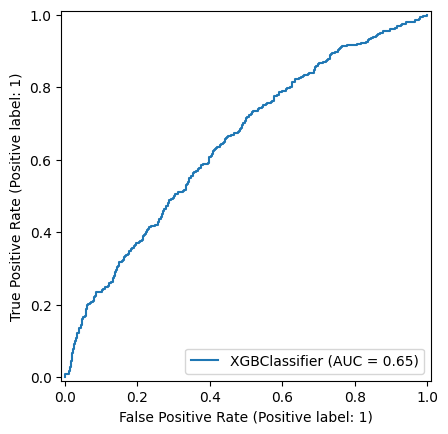

In [ ]:
models.append(classify(df,0.2,XGBClassifier(),"XGBClassifier"))

#### LGBM

[LightGBM] [Info] Number of positive: 1626, number of negative: 3118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1181
[LightGBM] [Info] Number of data points in the train set: 4744, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342749 -> initscore=-0.651069
[LightGBM] [Info] Start training from score -0.651069
----------------------------------------------------------------------------------------------------
Model name: LGBMClassifier
accuracy_score: 0.654300168634064
roc_auc_score: 0.5658775750294109
precision_score: 0.509009009009009
f1_score: 0.3553459119496855
----------------------------------------------------------------------------------------------------


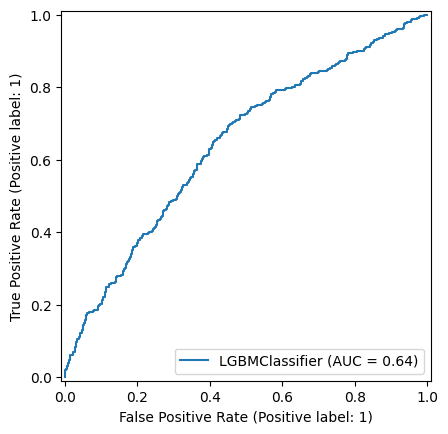

In [ ]:
models.append(classify(df,0.2,LGBMClassifier(),"LGBMClassifier"))

#### Comparision

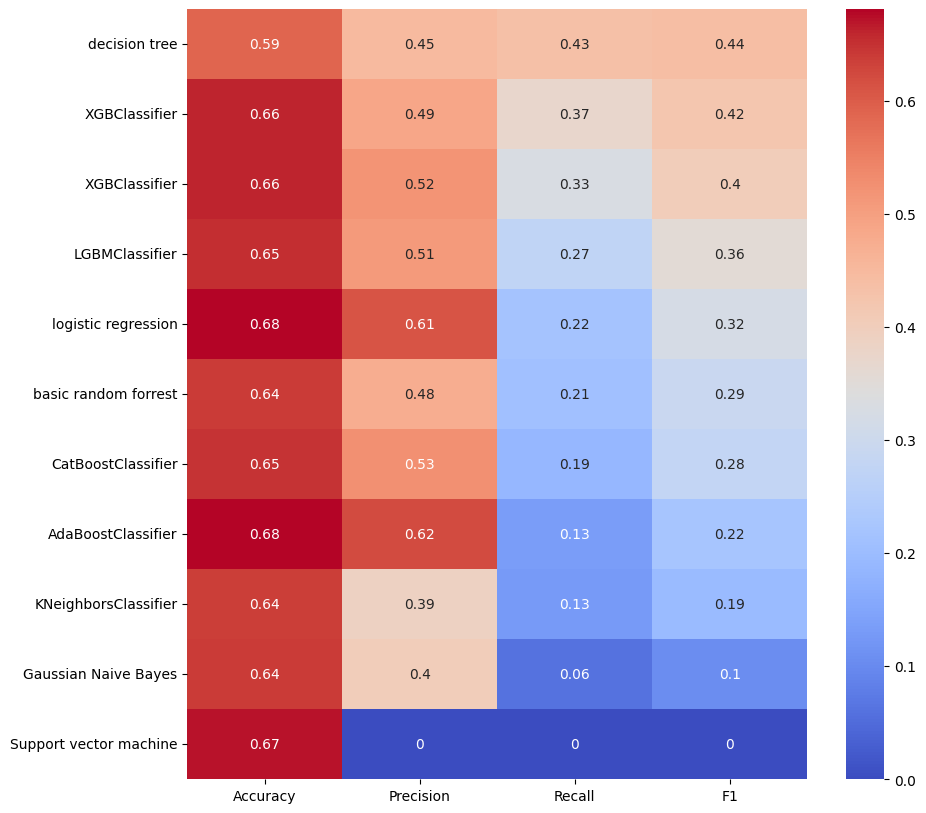

In [ ]:
compare_model_results(models)